In [ ]:
! pip install scikeras
! pip install git+https://github.com/modAL-python/modAL.git

## **Imports**:

In [ ]:
# =====================================================
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# =====================================================
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from modAL.models import ActiveLearner
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
# =====================================================
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
# =====================================================
from modAL.uncertainty import entropy_sampling, margin_sampling
from modAL.models import Committee
from modAL.disagreement import vote_entropy_sampling
# =====================================================
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
# =====================================================

## **Load Images:**

In [3]:
def Load_Images(main_folder_path):
    images = []
    labels = []
    label_mapping = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
    
    for label in os.listdir(main_folder_path):
        label_path = os.path.join(main_folder_path, label)
        label_value = label_mapping[label]
        
        for filename in os.listdir(label_path):
            image_path = os.path.join(label_path, filename)
            image = load_img(image_path, target_size=(224, 224))
            arrayed_image = img_to_array(image)
            normalized_image = arrayed_image / 255.0
            images.append(normalized_image)
            labels.append(label_value)
                
    return np.array(images), np.array(labels)

In [4]:
Flower_Images, Flower_Labels = Load_Images('../input/flowers')

## **Splitting Data:**

In [5]:
X_train, X_test_split, Y_train, Y_test_split = train_test_split(Flower_Images, Flower_Labels, test_size=0.5, random_state=42)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test_split, Y_test_split, test_size=0.5, random_state=42)

## **Preparing Model:**

In [6]:
def nn_model():
    Input_Layer = Input(shape=(224, 224, 3))
    MobileNet_Model = keras.applications.MobileNet(
                                                    alpha=1.0,
                                                    depth_multiplier=1,
                                                    dropout=0.001,
                                                    include_top=False,
                                                    weights="imagenet",
                                                    input_tensor=Input_Layer
                                                   )
    MobileNet_Model.trainable = False
    
    Pooled_output = GlobalAveragePooling2D()(MobileNet_Model.output)
    Densed_output = Dense(128, activation='tanh')(Pooled_output)
    Output_Layer = Dense(5, activation = 'softmax')(Densed_output)

    mobile_model = Model(inputs = MobileNet_Model.input, outputs = Output_Layer)
    mobile_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    mobile_model = KerasClassifier(mobile_model)
    return mobile_model

## **Preparing for Active Learning:**

In [7]:
def initial_data(X_train):
    n_initial = 682
    np.random.seed(2)
    initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
    X_initial = X_train[initial_idx]
    Y_initial = Y_train[initial_idx]

    # generate the pool
    # remove the initial data from the training dataset
    X_pool = np.delete(X_train, initial_idx, axis=0)
    Y_pool = np.delete(Y_train, initial_idx, axis=0)
    
    return X_initial, Y_initial, X_pool, Y_pool

In [8]:
def create_learner(classifier, query, X_initial_features, Y_initial):
    learner = ActiveLearner(
                             estimator = classifier,
                             query_strategy = query,
                             X_training = X_initial_features, y_training = Y_initial,
                             verbose = 1
                           )
    accuracy = learner.score(X_initial_features, Y_initial)
    print("Accuracy on initial data: ", accuracy)
    return learner

In [9]:
def create_loop(cycles, instances, learner, X_pool, Y_pool, classifier, X_validate, Y_validate):
    f1_scores = []
    for idx in range(cycles):
        print('Query no. %d' % (idx + 1))
        
        query_idx, query_instance = learner.query(X_pool, n_instances=instances)
        learner.teach(
                        X=X_pool[query_idx], y=Y_pool[query_idx], only_new=False
                     )
        y_pred = classifier.predict(X_validate)
        f1_micro = f1_score(Y_validate, y_pred, average='weighted')
        f1_scores.append(f1_micro)
        print(f"F1-score (Micro) for iteration {idx}:", f1_micro)

        # remove queried instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        Y_pool = np.delete(Y_pool, query_idx, axis=0)
        
    return f1_scores, y_pred, X_pool, Y_pool, classifier

## **Preparing for Evaluation:**

In [10]:
def testing(X_test, Y_test, classifier):
    Y_pred = classifier.predict(X_test)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    return Y_pred, f1

In [11]:
def plotting_scores(f1_scores, query):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(f1_scores)), f1_scores, marker='o')
    plt.xlabel('Active Learning Cycle')
    plt.ylabel('F1Score')
    plt.title(f'F1 Score Improvment with {query} ')
    plt.grid(True)
    plt.show()

In [12]:
def compute_confusion_matrix(Y_test, y_pred, color, query):
    
    cm = confusion_matrix(Y_test, y_pred)

    class_names =["Daisy", "Dandelion", "Rose", "Sunflower", "Tulip"]

    sns.heatmap(cm, 
                annot=True,
                cmap = color,
                fmt='g', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title(f'Confusion Matrix using {query}', fontsize=14)
    plt.show()

## **Without Active Learnig:**

In [36]:
nn_model_before = nn_model()
nn_model_before.fit(X_train, Y_train, batch_size=128, epochs=10)

/tmp/ipykernel_34/1163794226.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


Epoch 1/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:14 5s/step - accuracy: 0.1562 - loss: 1.8816

W0000 00:00:1714483189.896425     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.4970 - loss: 1.2275
Epoch 2/10


W0000 00:00:1714483193.061169     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8659 - loss: 0.4013
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9110 - loss: 0.2696
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9375 - loss: 0.2049
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9670 - loss: 0.1553
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9760 - loss: 0.1271
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9860 - loss: 0.0944
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9907 - loss: 0.0815
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9940 - loss: 0.0607
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9946 - loss: 0.0586


KerasClassifier(
	model=<Functional name=functional_17, built=True>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [42]:
Y_pred_before,f1 = testing(X_test, Y_test, classifier)
print(f'f1 score without active lr: {f1}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
f1 score without active lr: 0.9073533676734444


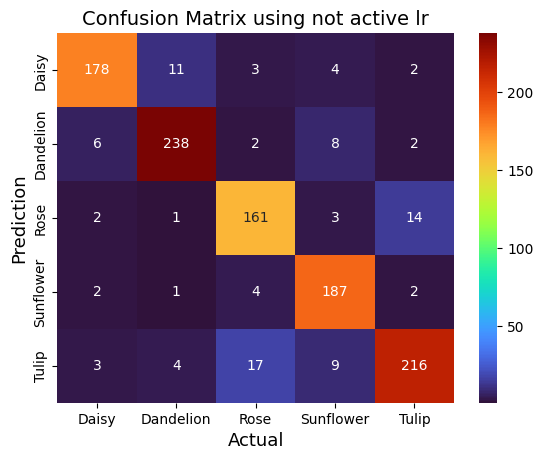

In [44]:
compute_confusion_matrix(Y_test, Y_pred_before,'turbo', 'not active lr')

### **Entropy Sampling:**

In [13]:
# trying with entropy sampling

X_initial, Y_initial, X_pool, Y_pool = initial_data(X_train)

nn_model_entropy = nn_model()

act_learner1 = create_learner(nn_model_entropy, entropy_sampling, X_initial, Y_initial)
f1_scores_entropy, _, _, _, nn_model_entropy = create_loop(10, 5, act_learner1, X_pool, Y_pool, nn_model_entropy, X_validate, Y_validate)

/tmp/ipykernel_35/2139366718.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4085 - loss: 1.5312

I0000 00:00:1714483737.490137     155 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714483737.512237     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.5466 - loss: 1.1780


W0000 00:00:1714483741.389292     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

W0000 00:00:1714483744.114861     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


W0000 00:00:1714483746.272310     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy on initial data:  0.8841642228739003
Query no. 1
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


W0000 00:00:1714483751.707864     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9066 - loss: 0.3370
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step


W0000 00:00:1714483763.573744     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


F1-score (Micro) for iteration 0: 0.8582599416103309
Query no. 2
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step


W0000 00:00:1714483771.333488     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9430 - loss: 0.2141


W0000 00:00:1714483777.489172     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (Micro) for iteration 1: 0.8659508551375161
Query no. 3
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step


W0000 00:00:1714483787.153779     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.9521 - loss: 0.1594


W0000 00:00:1714483793.685389     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 2: 0.8817695351378106
Query no. 4
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step


W0000 00:00:1714483803.148889     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.9813 - loss: 0.0897


W0000 00:00:1714483810.103240     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (Micro) for iteration 3: 0.8760128752800245
Query no. 5
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step


W0000 00:00:1714483818.962342     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9927 - loss: 0.0844


W0000 00:00:1714483823.561152     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 4: 0.8827131241155413
Query no. 6
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9944 - loss: 0.0581


W0000 00:00:1714483837.268909     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 5: 0.881543173052205
Query no. 7
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


W0000 00:00:1714483845.429363     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9964 - loss: 0.0432


W0000 00:00:1714483850.898562     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 6: 0.88321761984825
Query no. 8
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.9923 - loss: 0.0458


W0000 00:00:1714483864.693976     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 7: 0.8815575288787606
Query no. 9
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step


W0000 00:00:1714483874.518244     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9969 - loss: 0.0272


W0000 00:00:1714483878.154746     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 8: 0.8826419345989166
Query no. 10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9935 - loss: 0.0336


W0000 00:00:1714483887.474351     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 9: 0.8817698825040182


In [14]:
print(f1_scores_entropy)

[0.8582599416103309, 0.8659508551375161, 0.8817695351378106, 0.8760128752800245, 0.8827131241155413, 0.881543173052205, 0.88321761984825, 0.8815575288787606, 0.8826419345989166, 0.8817698825040182]


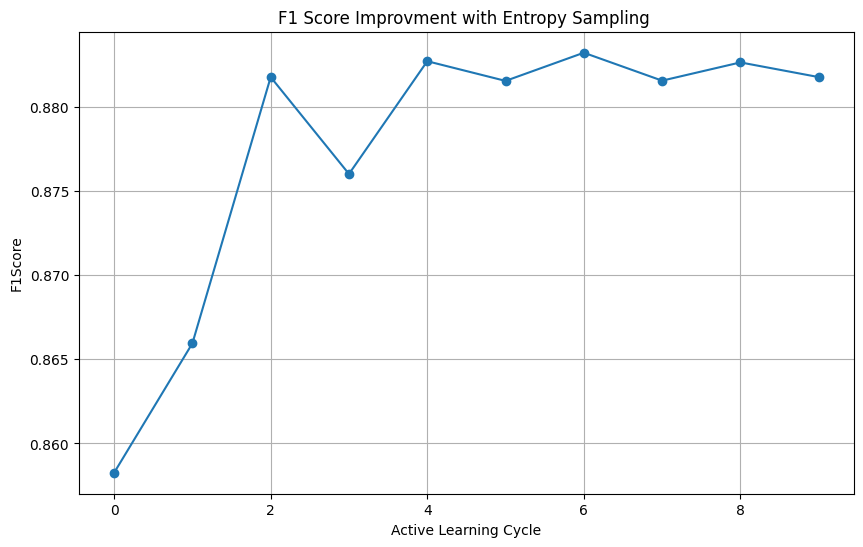

In [15]:
plotting_scores(f1_scores_entropy, 'Entropy Sampling')

In [17]:
Y_pred, score = testing(X_test, Y_test, nn_model_entropy )
print(f'F1 Score on test data using Entropy Sampling: {score:.2f}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step
F1 Score on test data using Entropy Sampling: 0.87


W0000 00:00:1714483953.781792     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


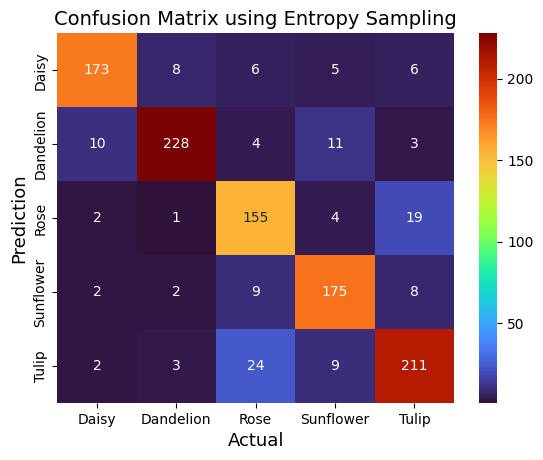

In [18]:
compute_confusion_matrix(Y_test, Y_pred, 'turbo', 'Entropy Sampling')

In [19]:
import joblib
joblib.dump(nn_model_entropy, 'nn_model_entropy.pkl')
# final_classifier = joblib.load('/kaggle/working/nn_model_entropy.pkl')

['nn_model_entropy.pkl']

## **Margin Sampling:**

In [13]:
# trying with margin sampling

X_initial, Y_initial, X_pool, Y_pool = initial_data(X_train)

nn_model_margin = nn_model()

act_learner2 = create_learner(nn_model_margin, margin_sampling, X_initial, Y_initial)
f1_scores_margin, _, _, _, nn_model_margin = create_loop(10, 5, act_learner2, X_pool, Y_pool, nn_model_margin, X_validate, Y_validate)

/tmp/ipykernel_34/2139366718.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2698 - loss: 1.6906

I0000 00:00:1714484195.589984     158 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.4680 - loss: 1.2762
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step
Accuracy on initial data:  0.8914956011730205
Query no. 1
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.8734 - loss: 0.3799
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
F1-score (Micro) for iteration 0: 0.8575714110733152
Query no. 2
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.9537 - loss: 0.2090
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
F1-score (Micro) for iteration 1: 0.8763582087075089
Query no. 3
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9675 - loss: 0.1430
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
F1-score (Micro) for iteration 2: 0.8770642409614239
Query no. 4
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.9821 - loss: 0.1113
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
F1-score (M

In [14]:
print(f1_scores_margin)

[0.8575714110733152, 0.8763582087075089, 0.8770642409614239, 0.8881411186793619, 0.885024415985392, 0.8779251664004207, 0.8822989701360476, 0.8868467253922647, 0.8824929338874942, 0.8805772852139424]


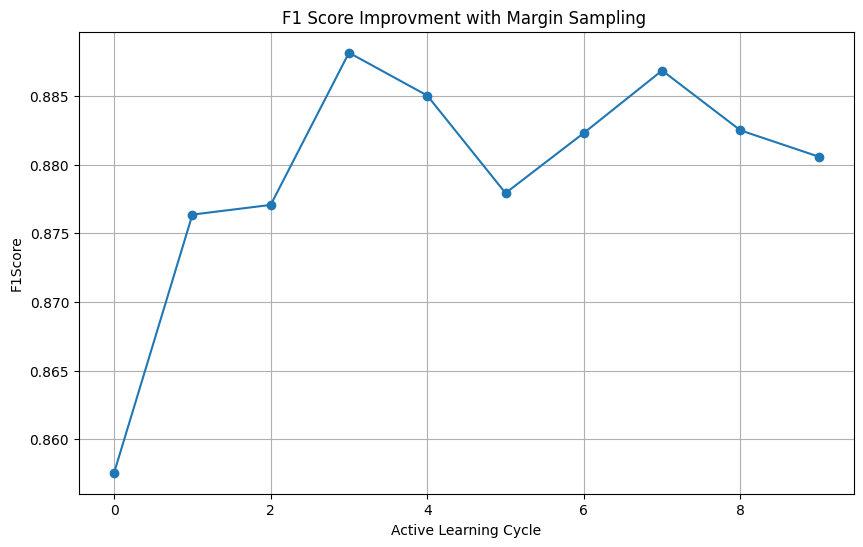

In [15]:
plotting_scores(f1_scores_margin, 'Margin Sampling')

In [16]:
Y_pred, score = testing(X_test, Y_test, nn_model_margin)
print(f'F1 Score on test data using Margin Sampling: {score:.2f}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
F1 Score on test data using Margin Sampling: 0.88


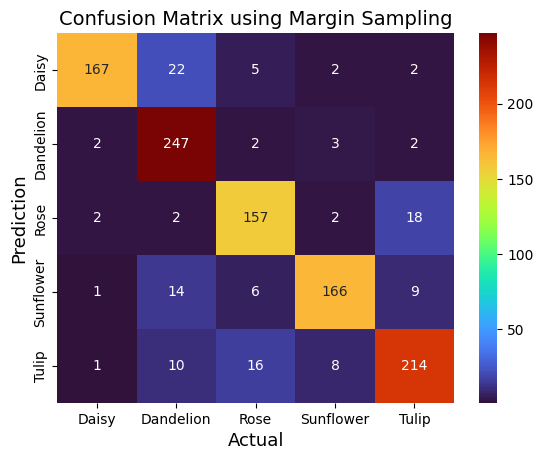

In [17]:
compute_confusion_matrix(Y_test, Y_pred, 'turbo', 'Margin Sampling')

In [18]:
import joblib
joblib.dump(nn_model_margin, 'nn_model_margin.pkl')
# final_classifier = joblib.load('/kaggle/working/nn_model_margin.pkl')

['nn_model_margin.pkl']

## **Query-By-Committee (Vote Entropy):**

In [13]:
# trying with vote entropy sampling query by committee

X_initial, Y_initial, X_pool, Y_pool = initial_data(X_train)
X_initial2, Y_initial2, X_pool2, Y_pool2 = initial_data(X_train)

nn_model_committee = nn_model()

learner1 = create_learner(nn_model_committee, entropy_sampling, X_initial, Y_initial)
learner2 = create_learner(nn_model_committee, margin_sampling, X_initial2, Y_initial2)

# a list of ActiveLearners:
learners = [learner1, learner2]

committee = Committee(
                       learner_list = learners,
                       query_strategy = vote_entropy_sampling
                     )

f1_scores_committee, _, _, _, nn_model_committee = create_loop(10, 5, committee, X_pool, Y_pool, nn_model_committee, X_validate, Y_validate)

/tmp/ipykernel_34/2139366718.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3142 - loss: 1.5013

I0000 00:00:1714485417.537197     163 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714485417.563921     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.5404 - loss: 1.1058


W0000 00:00:1714485421.575295     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 8/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

W0000 00:00:1714485433.987206     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step


W0000 00:00:1714485436.247345     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy on initial data:  0.8988269794721407
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9144 - loss: 0.3011
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy on initial data:  0.9281524926686217
Query no. 1
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


W0000 00:00:1714485444.958920     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9451 - loss: 0.1820


W0000 00:00:1714485453.970235     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9730 - loss: 0.1070
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step


W0000 00:00:1714485461.992872     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


F1-score (Micro) for iteration 0: 0.8626438187430215
Query no. 2
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step


W0000 00:00:1714485469.798280     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 1.0000 - loss: 0.0593


W0000 00:00:1714485479.395679     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0442
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
F1-score (Micro) for iteration 1: 0.8705103460865057
Query no. 3
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step


W0000 00:00:1714485490.869729     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 1.0000 - loss: 0.0310


W0000 00:00:1714485500.787518     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0237
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
F1-score (Micro) for iteration 2: 0.8703805961879874
Query no. 4
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step


W0000 00:00:1714485512.034579     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 1.0000 - loss: 0.0170


W0000 00:00:1714485522.473871     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0160
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
F1-score (Micro) for iteration 3: 0.8723943115000453
Query no. 5
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 0.0131


W0000 00:00:1714485545.674280     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0103
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
F1-score (Micro) for iteration 4: 0.8723479465511815
Query no. 6
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step


W0000 00:00:1714485556.225651     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 1.0000 - loss: 0.0083


W0000 00:00:1714485564.778600     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0086
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
F1-score (Micro) for iteration 5: 0.8769536928331771
Query no. 7
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


W0000 00:00:1714485574.811610     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.9970 - loss: 0.0134


W0000 00:00:1714485583.733980     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0064
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
F1-score (Micro) for iteration 6: 0.8749382445910006
Query no. 8
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.9975 - loss: 0.0132


W0000 00:00:1714485602.740205     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0063
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
F1-score (Micro) for iteration 7: 0.8722284953569881
Query no. 9
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step


W0000 00:00:1714485615.059166     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 0.0049


W0000 00:00:1714485622.102472     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0046
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
F1-score (Micro) for iteration 8: 0.8759141258252275
Query no. 10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0040


W0000 00:00:1714485636.771561     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.0000 - loss: 0.0032
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
F1-score (Micro) for iteration 9: 0.8740743366711549


In [14]:
print(f1_scores_committee)

[0.8626438187430215, 0.8705103460865057, 0.8703805961879874, 0.8723943115000453, 0.8723479465511815, 0.8769536928331771, 0.8749382445910006, 0.8722284953569881, 0.8759141258252275, 0.8740743366711549]


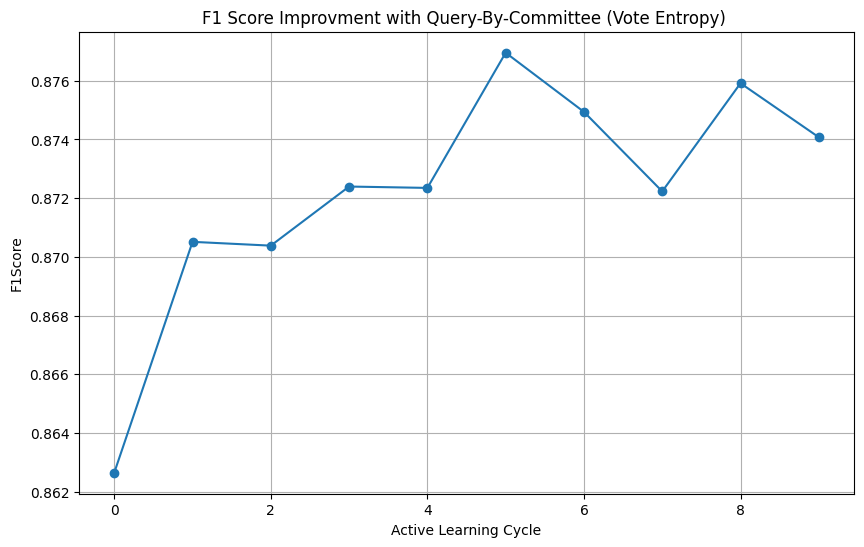

In [15]:
plotting_scores(f1_scores_committee, 'Query-By-Committee (Vote Entropy)')

In [16]:
Y_pred, score = testing(X_test, Y_test, nn_model_committee)
print(f'F1 Score on test data using Query-By-Committee (Vote Entropy): {score:.2f}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step
F1 Score on test data using Query-By-Committee (Vote Entropy): 0.87


W0000 00:00:1714485647.897491     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


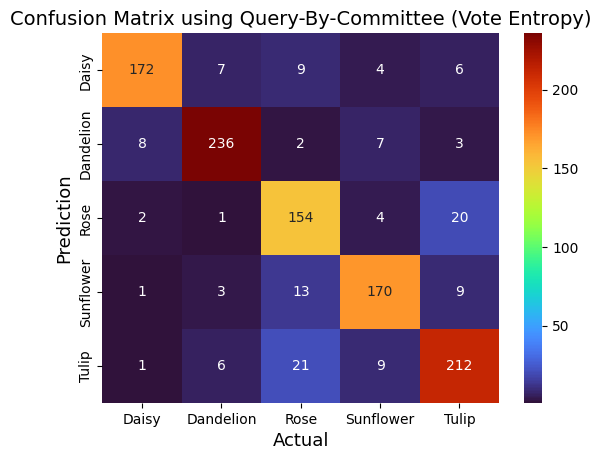

In [17]:
compute_confusion_matrix(Y_test, Y_pred, 'turbo', 'Query-By-Committee (Vote Entropy)')

In [ ]:
import joblib
joblib.dump(nn_model_committee, 'nn_model_committee.pkl')
# final_classifier = joblib.load('/kaggle/working/nn_model_committee.pkl')

## **Random Sampling:**

In [15]:
def random_sampling(classifier, X, n_instances):
    
    pool_size = len(X)
    
    pool_indices = np.arange(pool_size)
    
    np.random.shuffle(pool_indices)
    
    query_idx = pool_indices[:n_instances]
    
    query_instances = X[query_idx]
    
    return query_idx, query_instances

In [16]:
# trying with random sampling

X_initial, Y_initial, X_pool, Y_pool = initial_data(X_train)

nn_model_random = nn_model()

act_learner3 = create_learner(nn_model_random, random_sampling, X_initial, Y_initial)
f1_scores_random, _, _, _, nn_model_random = create_loop(10, 5, act_learner3, X_pool, Y_pool, nn_model_random, X_validate, Y_validate)

/tmp/ipykernel_34/2139366718.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_Model = keras.applications.MobileNet(


 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3189 - loss: 1.7694

W0000 00:00:1714486452.778776     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.4936 - loss: 1.2739


W0000 00:00:1714486454.877774     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

W0000 00:00:1714486457.464532     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step


W0000 00:00:1714486459.462600     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy on initial data:  0.8826979472140762
Query no. 1
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.8769 - loss: 0.3753


W0000 00:00:1714486465.097800     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step


W0000 00:00:1714486471.515075     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


F1-score (Micro) for iteration 0: 0.8549107686209416
Query no. 2
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.9576 - loss: 0.1969


W0000 00:00:1714486478.193014     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (Micro) for iteration 1: 0.8602868104982927
Query no. 3
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.9768 - loss: 0.1308


W0000 00:00:1714486487.476592     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 2: 0.8737625572188586
Query no. 4
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.9936 - loss: 0.0796


W0000 00:00:1714486497.196071     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
F1-score (Micro) for iteration 3: 0.8735236612103514
Query no. 5
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9980 - loss: 0.0641


W0000 00:00:1714486504.597801     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 4: 0.877038781427728
Query no. 6
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9946 - loss: 0.0579


W0000 00:00:1714486512.451252     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (Micro) for iteration 5: 0.8754408324385596
Query no. 7
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.9982 - loss: 0.0398


W0000 00:00:1714486520.663123     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 6: 0.8782570775272249
Query no. 8
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 1.0000 - loss: 0.0299


W0000 00:00:1714486529.403036     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 7: 0.8798798137801289
Query no. 9
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 1.0000 - loss: 0.0166


W0000 00:00:1714486535.697840     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 8: 0.8826341582247644
Query no. 10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 1.0000 - loss: 0.0163


W0000 00:00:1714486545.329854     161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 9: 0.8852080125295847


In [17]:
print(f1_scores_random)

[0.8549107686209416, 0.8602868104982927, 0.8737625572188586, 0.8735236612103514, 0.877038781427728, 0.8754408324385596, 0.8782570775272249, 0.8798798137801289, 0.8826341582247644, 0.8852080125295847]


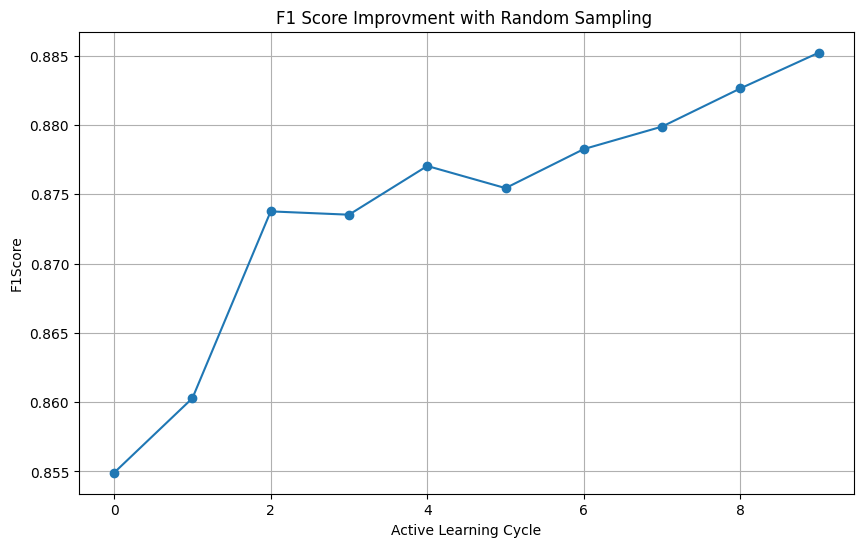

In [18]:
plotting_scores(f1_scores_random, 'Random Sampling')

In [19]:
Y_pred, score = testing(X_test, Y_test, nn_model_random)
print(f'F1 Score on test data using Random Sampling: {score:.2f}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step
F1 Score on test data using Random Sampling: 0.88


W0000 00:00:1714486560.145979     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


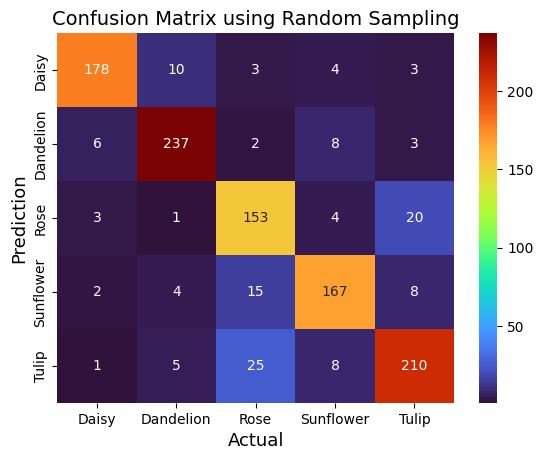

In [20]:
compute_confusion_matrix(Y_test, Y_pred,'turbo', 'Random Sampling')

In [ ]:
import joblib
joblib.dump(nn_model_random, 'nn_model_random.pkl')
# final_classifier = joblib.load('/kaggle/working/nn_model_random.pkl')

## **Putting All Plots Together**

In [22]:
f1_nn_entropy = [0.8582599416103309, 0.8659508551375161, 0.8817695351378106, 0.8760128752800245, 0.8827131241155413, 0.881543173052205, 0.88321761984825, 0.8815575288787606, 0.8826419345989166, 0.8817698825040182]
f1_nn_margin = [0.8575714110733152, 0.8763582087075089, 0.8770642409614239, 0.8881411186793619, 0.885024415985392, 0.8779251664004207, 0.8822989701360476, 0.8868467253922647, 0.8824929338874942, 0.8805772852139424]
f1_nn_committee = [0.8626438187430215, 0.8705103460865057, 0.8703805961879874, 0.8723943115000453, 0.8723479465511815, 0.8769536928331771, 0.8749382445910006, 0.8722284953569881, 0.8759141258252275, 0.8740743366711549]
f1_nn_random = [0.8549107686209416, 0.8602868104982927, 0.8737625572188586, 0.8735236612103514, 0.877038781427728, 0.8754408324385596, 0.8782570775272249, 0.8798798137801289, 0.8826341582247644, 0.8852080125295847]

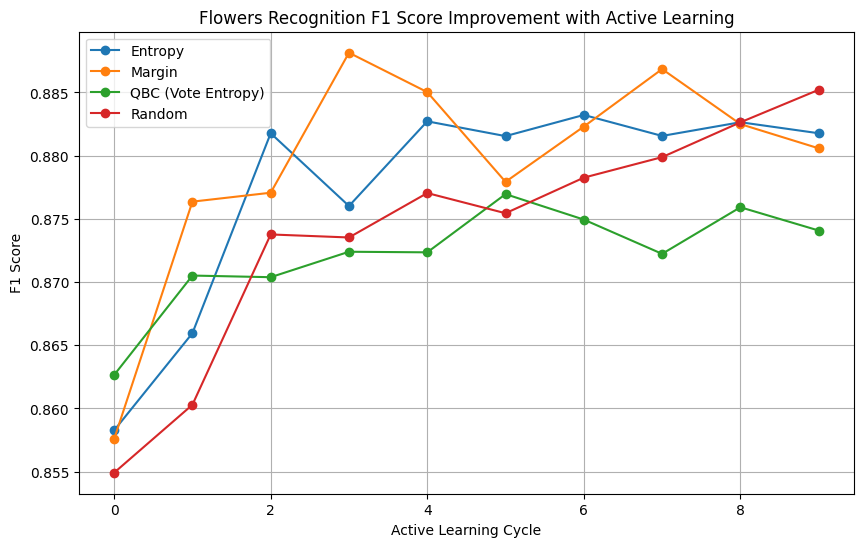

In [23]:
# Plotting F1 scores over cycles for all four strategies
plt.figure(figsize=(10, 6))

# Plotting F1 scores values for strategy 1
plt.plot(range(len(f1_nn_entropy)), f1_nn_entropy, marker='o', label='Entropy')

# Plotting F1 scores values for strategy 2
plt.plot(range(len(f1_nn_margin)), f1_nn_margin, marker='o', label='Margin')

# Plotting F1 scores values for strategy 3
plt.plot(range(len(f1_nn_committee)), f1_nn_committee, marker='o', label='QBC (Vote Entropy)')

# Plotting F1 scores values for strategy 4
plt.plot(range(len(f1_nn_random)), f1_nn_random, marker='o', label='Random')

plt.xlabel('Active Learning Cycle')
plt.ylabel('F1 Score')
plt.title('Flowers Recognition F1 Score Improvement with Active Learning')
plt.grid(True)
plt.legend()
plt.show()